В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [36]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, roc_auc_score, roc_curve

In [37]:
raw_df = pd.read_csv('kaggle_data/train.csv')

In [38]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [39]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [40]:
raw_df['Exited'].value_counts(normalize=True)

Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64

In [41]:
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

In [42]:
print('train_df shape :', train_df.shape)

train_df shape : (12000, 14)


In [43]:
print('val_df shape :', val_df.shape)

val_df shape : (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [44]:
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [45]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

print('numeric_cols:', numeric_cols)
print('categorical_cols:', categorical_cols)

numeric_cols: ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
categorical_cols: ['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [46]:
train_inputs[numeric_cols].describe().round(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,15690923.99,658.84,37.69,5.03,43008.17,1.59,0.79,0.49
std,146930.97,72.33,8.14,2.78,59906.63,0.53,0.41,0.50
min,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00
25%,15635116.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00
50%,15689953.00,661.00,37.00,5.00,0.00,2.00,1.00,0.00
75%,15756921.50,708.00,42.00,7.00,109949.05,2.00,1.00,1.00
max,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00


In [47]:
raw_df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.569146e+07,658.944133,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667
std,1.352050e+05,72.255926,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910
min,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.563514e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000
50%,1.569018e+07,662.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000
75%,1.575718e+07,708.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000
95%,1.579896e+07,773.000000,54.000000,9.000000,145129.762000,2.000000,1.000000,1.000000
99%,1.580930e+07,850.000000,63.000000,10.000000,166501.344600,3.000000,1.000000,1.000000
max,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000


In [48]:
# Scale numeric features
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [49]:
display(train_inputs.head())
display(val_inputs.head())

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.988516,Mays,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
10393,0.984351,Ch'eng,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
80,0.997112,Ch'in,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3365,0.997533,K?,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12236,0.987805,Trevisani,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Surname_Zito,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.998500,Pirozzi,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3646,0.986066,Ritchie,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5306,0.998048,Hs?eh,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
652,0.999135,Onio,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2627,0.996960,Genovesi,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


**Висновок:**
- Застосував StandardScaler, для маштабування числових даних.
- Використав OneHotEncoder для перетворення текстових категорій на бінарні.

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [50]:
pd.DataFrame(train_inputs).to_parquet('parquet_data/train_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('parquet_data/train_targets.parquet')
pd.DataFrame(val_inputs).to_parquet('parquet_data/val_inputs.parquet')
pd.DataFrame(val_targets).to_parquet('parquet_data/val_targets.parquet')

In [51]:
!ls 'parquet_data'

train_inputs.parquet   val_inputs.parquet
train_targets.parquet  val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [52]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Training F1 Score: 0.67


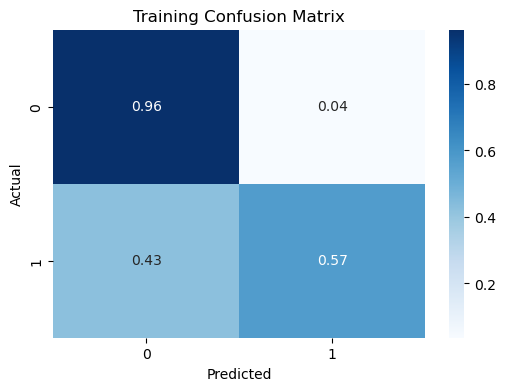

AUROC for Training: 0.90


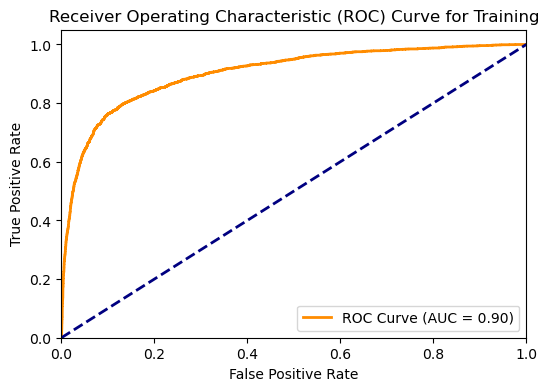

Validation F1 Score: 0.64


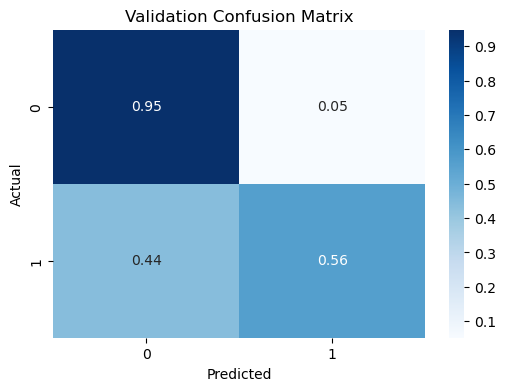

AUROC for Validation: 0.88


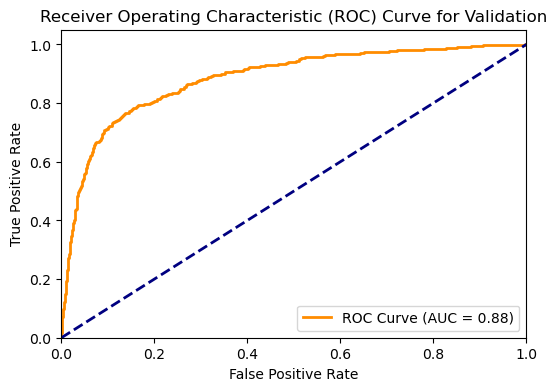

In [53]:
def predict_and_evaluate_model(inputs, targets, name=''):
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    y_preds = (y_pred_proba >= 0.5).astype(int)

    f1 = f1_score(targets, y_preds)
    print(f'{name} F1 Score: {f1:.2f}')
    
    cf_matrix = confusion_matrix(targets, y_preds, normalize='true')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc='lower right')
    plt.show()

    return y_preds
train_preds = predict_and_evaluate_model(X_train, train_targets, name='Training')
val_preds = predict_and_evaluate_model(X_val, val_targets, name='Validation')

**Висновок:**
- ROC крива для тренувальних даних 0.90 для валідаційних даних 0.88.
- F1 Score для тренувальних даних 0.67 для валідаційних даних 0.64.
- модель має хороші результати на тренувальних даних і трохи слабші на валідаційних.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [54]:
majority_class = train_targets.mode()[0]
print(f'Majority class: {majority_class}')

train_majority_predictions = np.full(len(X_train), majority_class)
val_majority_predictions = np.full(len(X_val), majority_class)

train_majority_acc = accuracy_score(train_targets, train_majority_predictions)
val_majority_acc = accuracy_score(val_targets, val_majority_predictions)

print(f'Majority class model accuracy on training data: {train_majority_acc:.2f}')
print(f'Majority class model accuracy on validation data: {val_majority_acc:.2f}')

train_acc = accuracy_score(train_targets, train_preds)
val_acc = accuracy_score(val_targets, val_preds)

print(f'Logistic regression model accuracy on training data: {train_acc:.2f}')
print(f'Logistic regression model accuracy on validation data: {val_acc:.2f}')

Majority class: 0.0
Majority class model accuracy on training data: 0.80
Majority class model accuracy on validation data: 0.80
Logistic regression model accuracy on training data: 0.88
Logistic regression model accuracy on validation data: 0.87


**Висновок:**
Модель має 87% точності, що на 7% краще ніж мажоритарний клас. 

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [55]:
value = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
}
joblib.dump(value, 'joblib_data/log_reg.joblib')

['joblib_data/log_reg.joblib']

In [56]:
model_2 = joblib.load('joblib_data/log_reg.joblib')['model']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [57]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, encoded_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [58]:
predict_raw_df(scaler, encoder, numeric_cols, encoded_cols, categorical_cols, raw_df[:5])

array([0.00593626, 0.03173026, 0.60798778, 0.30771648, 0.9736265 ])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [59]:
test_raw_df = pd.read_csv('kaggle_data/test.csv')

test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, encoded_cols, categorical_cols, test_raw_df)
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_Zox,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,0.984482,Chu,0.365155,Germany,Male,0.214286,0.2,0.696265,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.021929
1,15001,0.987856,Mazzi,0.286396,France,Male,0.375000,0.5,0.000000,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.050255
2,15002,0.993017,Onyekachi,0.656325,France,Male,0.446429,0.8,0.000000,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.071480
3,15003,0.997849,Martin,0.682578,Spain,Male,0.482143,0.3,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.287435
4,15004,0.989270,Kenechukwu,0.384248,Spain,Male,0.446429,0.8,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.035197


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [60]:
submission_df = pd.read_csv('kaggle_data/sample_submission.csv')

submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [61]:
submission_df['Exited'] = test_raw_df.set_index('id').loc[submission_df['id'], 'Exited'].values
submission_df.to_csv('kaggle_data/submission_log_reg.csv', index=False)
submission_df.head()

,id,Exited
0,15000,0.021929
1,15001,0.050255
2,15002,0.071480
3,15003,0.287435
4,15004,0.035197
